<a href="https://colab.research.google.com/github/you444Mo/Python-Projects/blob/main/GEN_BUSA_740_Week_2_HW2_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GB 740 — Assignment 2 - Clinical sales experiment

**Context:**  
In this assignment, you will analyze (simulated) data from an experiment investigating different sales strategies.

A fictional company called Einfach Medical Supplies (EMS) sells a disposable testing device that primarycare medical clinics (i.e., “family doctors”) use to test for a fictional disease called Frog Throat. There
are a number of competitors to EMS selling similar products. EMS believes they have the best product
in the market and that doctors will buy if they can get the clinic to hear their pitch. In the past they have found that once a doctor buys their test kit, the doctor often sticks with it, without more sales visits.

The big challenge for the sales team, though, is getting past the first few moments of trying to pitch the product when they first visit a clinic.
If they are successful, the sales people might be invited in right then to give a full pitch of the product to
the doctors and nurse practitioners in the clinic. They might also be able to schedule a follow up visit to
come back and give the pitch. Often, though, they are turned away when they first arrive and told the
clinic already has a Frog Throat Testing supplier that they are happy with.

EMS has just moved into a new region of the country and are trying to expand their business. Their
sales force works out of offices in a few different cities. The sales people have been assigned clinics to
visit and try to land sales.

In their initial expansion regions, EMS has had sales people use a script for their opening pitch to the
clinic that emphasizes the cost savings of their product over alternatives. Recently some of the sales
force has suggested that it might be better to lead with a pitch other than the “cost angle”. They
propose either a) leading first with the point that their product is much easier for the medical staff to
use or b) their product leads to fewer contaminated samples and a lower error rate.

The company has just hired a director of analytics and she proposed systematically testing whether
different opening pitches have different effects on conversion of clinics by using a randomized
controlled design. So in this new region the company took the clinics and randomized them into three
groups: a) Control that received the original “cost-focused” pitch, b) Treatment 1 that received the
“easier to use” pitch and c) Treatment 2 that received the “fewer errors” pitch. When the sales team
goes out to visit a clinic they see the pitch that was randomly selected for that clinic on their work iPad. The outcome metric is whether the clinic bought any test kits on the day of the sales visit.

The file “clinicsales.csv” available on the course site has the results of the experiment.

**Data:** The dataset is `“clinicsales.csv` on the canvas page and also on course GitHub page.

**Deliverable:** Submit a **shareable link to your completed Colab notebook** with all steps answered


## Variables

- `clinicnumber`: The id of the clinic. These were randomly assigned and have no underlying meaning.  
- `numdoctors`: The number of doctors working at the clinic  
- `avgpanelsize`: An estimate of the average number of patients each of the doctors at this clinic has in
  their panel. These are patients who list the doctor as their primary care physician.  
- `distance`: The distance (in miles) between the clinic and the sales office assigned to pitch that clinic.  
- `treatment`: Takes value 0 for control, 1 for Treatment 1, 2 for Treatment 2  
- `purchase`: Takes a value of 0 and 1. 0 if the clinic declined to purchase test kits from EMS on the day of the sales visit and 1 if they did
  purchase test kits from EMS.  


### Setup
Run this cell once per session.

In [3]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

### 0. Read in the Data

In [4]:
Clinic_SalesDF = pd.read_csv("/content/clinicsales.csv")

### Check Variables
Clinic_SalesDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 321 entries, 0 to 320
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   clinicnumber  321 non-null    int64
 1   treatment     321 non-null    int64
 2   purchase      321 non-null    int64
 3   numdoctors    321 non-null    int64
 4   avgpanelsize  321 non-null    int64
 5   distance      321 non-null    int64
dtypes: int64(6)
memory usage: 15.2 KB


#### Inital Analysis of Data:

In [5]:
### Check Stats
Clinic_SalesDF.describe()

,clinicnumber,treatment,purchase,numdoctors,avgpanelsize,distance
count,321.000000,321.000000,321.000000,321.000000,321.000000,321.000000
mean,161.732087,1.012461,0.249221,3.931464,2303.267913,35.383178
std,93.149627,0.821489,0.433237,1.170593,141.638437,43.075293
min,1.000000,0.000000,0.000000,1.000000,2050.000000,2.000000
25%,81.000000,0.000000,0.000000,3.000000,2186.000000,9.000000
50%,162.000000,1.000000,0.000000,4.000000,2308.000000,21.000000
75%,242.000000,2.000000,0.000000,5.000000,2419.000000,46.000000
max,322.000000,2.000000,1.000000,7.000000,2546.000000,437.000000


In [6]:
### View First Few Rows of Data
Clinic_SalesDF.head()

,clinicnumber,treatment,purchase,numdoctors,avgpanelsize,distance
0,108,2,1,6,2509,5
1,165,2,0,5,2340,7
2,205,1,0,4,2500,7
3,267,1,0,4,2073,8
4,36,2,0,4,2152,7


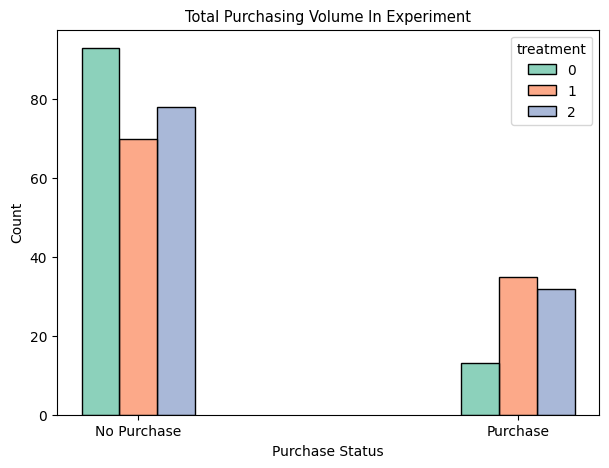

In [7]:
### See volume of purchase to non-purchase
plt.figure(figsize = (7,5))

sns.histplot(
    data = Clinic_SalesDF,
    x = 'purchase',
    binwidth= 1,
    binrange = (np.min(Clinic_SalesDF['purchase']) - 0.5, np.max(Clinic_SalesDF['purchase']) + 0.5), ### use this logic to center the histogram bins on tick
    shrink= 0.3,
    hue = 'treatment',
    multiple = 'dodge',
    palette="Set2"
)

plt.xticks([0,1],['No Purchase','Purchase'])
plt.xlabel("Purchase Status")
plt.title("Total Purchasing Volume In Experiment", fontsize = 10.5)
plt.show()

Right away, we see that for sales visits at clinics that ended in a sale, treatment 1 had the most sales, closely followed-up by treatment 2.

### 1. Evidence on the validity of the experiment / showing that the randomization was successful.

- Make a table showing the
    - means of each of the pre-experiment variables in each treatment arm
    - the number of observations in each treatment arm.

In [8]:
#### Pre Treatment variable statistics
Balance_Check = Clinic_SalesDF.groupby('treatment').agg(
    {
        'numdoctors' : 'mean',
        'avgpanelsize' : 'mean',
        'distance' : ['mean','count'],
    }
)

print(Balance_Check)

          numdoctors avgpanelsize   distance      
                mean         mean       mean count
treatment                                         
0           3.754717  2291.792453  38.028302   106
1           3.980952  2282.619048  35.161905   105
2           4.054545  2334.036364  33.045455   110


Pre-experiment variables:

* numdoctors, avgpanelsize, distance

Outcome metric:
* purchase

#### 1.a. Does the randomization seem successful? Provide a short explanation.

In terms of the sample size per treatment bucket, the randomization was <br> effective (321 total entries in the data, 106,105,110 in treatments 0,1,2).

In terms of the means for the pre experiment metrics: numdoctrs seams a little <br>skewed towards treamtment 2 (4.05 vs 3.98 for treatment 1 and 3.75 for the <br>control). Distance seems to be skewed a bit in the other direction (38 for <br> the control, 35 and 33 for treatments 1 and 2). I don't think the
<br> differences in means are too egregious, but something to monitor as we <br> move forward with analysis.

### 2. Show the means of all outcomes in each treatment arm, as well as 95% confidence intervals for the means.

In [9]:
### Set Z Score
zscore = 1.96 ### Assuming 95% CI (alpha: 0.05, alpha/2 = 0.025, 1 - 0.025 = 0.975)

Outcomes_DF = Clinic_SalesDF.groupby('treatment')['purchase'].agg(
    {
        'mean','std','count'
    }
)

### Calculate Standard Error For each Sample
Outcomes_DF['SE'] = Outcomes_DF['std'] / np.sqrt(Outcomes_DF['count'])

### Calculate Lower and Upper Bounds for Confidence Intervals
Outcomes_DF['CI_LB'] = Outcomes_DF['mean'] - (zscore * Outcomes_DF['SE'])
Outcomes_DF['CI_UB'] = Outcomes_DF['mean'] + (zscore * Outcomes_DF['SE'])

### View Means and CI
print("    Average Means & 95% CI of Purchasing Per Treatment Arm")
print("-----" * 12)
print(Outcomes_DF[['mean','CI_LB','CI_UB']])

    Average Means & 95% CI of Purchasing Per Treatment Arm
------------------------------------------------------------
               mean     CI_LB     CI_UB
treatment                              
0          0.122642  0.059898  0.185385
1          0.333333  0.242732  0.423934
2          0.290909  0.205644  0.376174


### 3. Show the ATEs for each outcome, as well las 95% confidence intervals for the ATE.

Hint:  In class we calculated ATEs for an experiment with one treatment arm.  Here we have multiple treatment arms. The "tabular" approach will work fine for this. However if you want to use regression with multiple treatment arms, you have to either (i) make a separate binary variable for each treatment arm, or treat treatment as a categorical variable, using formula = 'y~C(treatment)'. This tells python that treatment is a categorical variable.


#### 3.a show the ATEs for each outcome

In [10]:
### Fit OLS Regression on Data
formula = "purchase ~ C(treatment)" ### C() will tell statsmodels to treat the treatment variable as a categorical variable
model = smf.ols(formula = formula, data = Clinic_SalesDF).fit()
model = model.get_robustcov_results(cov_type= 'HC3')
### Show Summary
print(model.summary()) ### Beta Coefficents represent respective Average Treatment Affects (ATEs)

                            OLS Regression Results                            
Dep. Variable:               purchase   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     8.869
Date:                Wed, 12 Nov 2025   Prob (F-statistic):           0.000179
Time:                        07:21:30   Log-Likelihood:                -179.28
No. Observations:                 321   AIC:                             364.6
Df Residuals:                     318   BIC:                             375.9
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.1226      0.03

In [11]:
#### ATEs per Treatment Group
Treatment1_ATE = model.params[1]
Treatment2_ATE = model.params[2]
Treatment1_Pval = model.pvalues[1]
Treatment2_Pval = model.pvalues[2]

print(f"The ATE for treatment 1 is {Treatment1_ATE:.4f} with a p-value of {Treatment1_Pval:.3f}.")
print(f"The ATE for treatment 2 is {Treatment2_ATE:.4f} with a p-value of {Treatment2_Pval:.3f}.")

The ATE for treatment 1 is 0.2107 with a p-value of 0.000.
The ATE for treatment 2 is 0.1683 with a p-value of 0.002.


#### 3.b calculate and print the confidence intervals for the ATE

In [12]:
### Confidence Intervals for each Treatment's ATE
Treatment1_CI = model.conf_int()[1]
Treatment2_CI = model.conf_int()[2]

print(f"The 95% CI for treatment 1 is {Treatment1_CI}")
print(f"The 95% CI for treatment 2 is {Treatment2_CI}")

The 95% CI for treatment 1 is [0.09953819 0.32184546]
The 95% CI for treatment 2 is [0.06150951 0.27502565]


Graphs of: Means of Treatment Groups and ATE and CIs for Treatments 1 and 2:

In [13]:
### Bring ATE and ATE CIs into summary table
Outcomes_DF['ATE'] = Outcomes_DF['mean'] - Outcomes_DF['mean'].iloc[0]

Outcomes_DF['ATE_SE'] = np.sqrt(Outcomes_DF['SE'] ** 2 + Outcomes_DF['SE'].iloc[0] ** 2)

Outcomes_DF['ATE_CI_LB'] = Outcomes_DF['ATE'] - zscore * Outcomes_DF['ATE_SE']
Outcomes_DF['ATE_CI_UB'] = Outcomes_DF['ATE'] + zscore * Outcomes_DF['ATE_SE']

print(Outcomes_DF[['ATE','ATE_CI_LB','ATE_CI_UB']].iloc[1:3])

                ATE  ATE_CI_LB  ATE_CI_UB
treatment                                
1          0.210692   0.100486   0.320898
2          0.168268   0.062405   0.274130


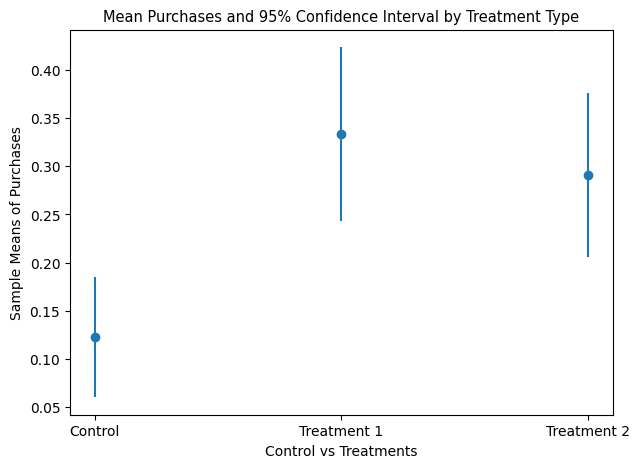

In [14]:
### Graph Means/CIs for each Treatment Group
plt.figure(figsize = (7,5))
plt.errorbar(y = Outcomes_DF['mean'], x = Outcomes_DF.index,
             yerr = zscore * Outcomes_DF['SE'], fmt = 'o') ### fmt = o makes it so this is a dot plot, no line in between 2 groups

plt.title("Mean Purchases and 95% Confidence Interval by Treatment Type", fontsize = 10.5)
plt.xlabel("Control vs Treatments")
plt.ylabel("Sample Means of Purchases")
plt.xticks([0,1,2], ['Control', 'Treatment 1', 'Treatment 2'])
plt.show()

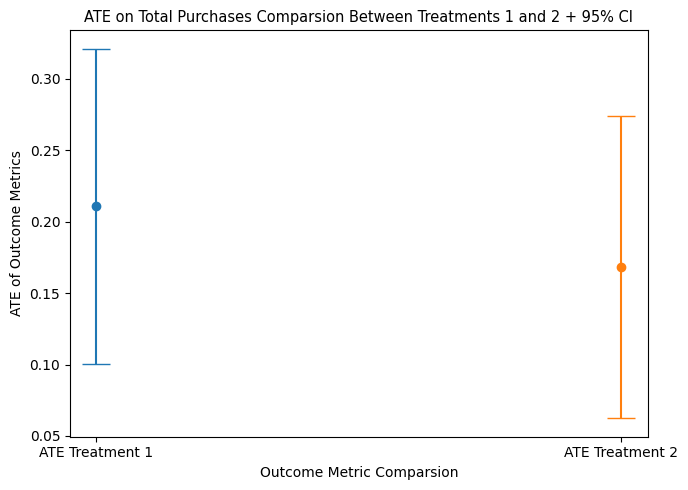

In [15]:
### Graph ATEs for Treatments 1 and 2
x1 = Outcomes_DF.index[[1,2]]  ### To compare ATEs, only need the test groups
y1 = Outcomes_DF['ATE'].iloc[1] ### Only grab test row 1
y2 = Outcomes_DF['ATE'].iloc[2] ### Only grab test row 2

### Set axis plot
fig, ax = plt.subplots(figsize = (7,5))
# offset = 0.5

# Plot 1 (treatment 1)
color1 = 'tab:blue'
ax.errorbar(
    y = y1, x = x1[0], yerr = zscore * Outcomes_DF['ATE_SE'].iloc[1], ### Grab indexes for treatment 1
    fmt = 'o', capsize = 10, label = 'ATE Treatment 1', color = color1) ### Capsize is the length of the end caps of each error bar

# Plot 2 (treatment 2)
color2 = 'tab:orange'
ax.errorbar(
    y = y2, x = x1[1], yerr = zscore * Outcomes_DF['ATE_SE'].iloc[2], ### Grab indexes for treatment 2
    fmt = 'o', capsize = 10, label = 'ATE Treatment 2', color = color2) ### Capsize is the length of the end caps of each error bar

### Axis Labels
ax.set_xlabel('Outcome Metric Comparsion')
ax.set_ylabel('ATE of Outcome Metrics')

### X axis ticks
ax.set_xticks([1,2]) ### Use the offset value
ax.set_xticklabels(['ATE Treatment 1','ATE Treatment 2'])

### Set Plot Title
plt.title("ATE on Total Purchases Comparsion Between Treatments 1 and 2 + 95% CI", fontsize = 10.5)


# Show Plot
plt.tight_layout()
plt.show()

### 4. A brief (1-3 sentence is fine) discussion of the business implications of the experiment. What should we do with the findings?

Overall, we see that the ATEs of Treatment 1 vs the control and Treatment 2 vs the control are: 0.2107 and 0.1683 (both positively associated with purchases, and are statistically significant (p-values below 0.05)). The confidence intervals for both treatment ATEs are roughly the same, with Treatment 2s CI being slightly wider. Treatment 1 looks to be the slight winner in this regard.

I think we can say with some confidence that both sales pitches 1 and 2 are more effective than the original pitch, but to truly decide which of the 2 pitches should be the "champion", I think an a/b test on another sample of clinics where we'd pit the 2 treatments against each other could be a good way to truley see which one is more effective, and thereby should be adobpted by the firm and scaled up.



### 5. Briefly discuss possible issues with the experiment (1-3 sentence is fine) about possible issues. Is the outcome metric ideal? Did you spot anything troubling in the balance checks or results? If everything is great, explain why. If you spot a problem, suggest a solution.


As I mentioned when we checked the balanced of the pre-experiment variables, the counts within each arm of the experiment were fine, but, the means between some of the variables (mainly numdoctors and distance) raised some flags to me.There were some clear skews towards either the control in once case, or towards treatment 2 in the other. These imbalances could be bringing on some unintended confounding to our populations, which if present, could make the results of our experiment harder to adopt and scale (due to unintended selection bias skewing the results).

I would run another test regardless of the imbalancing issue, as mentioned before. Given this flaw, I definetly would consider running this particular test again, paying more attention to how the experimental subgroups are split before we a/b test in order to get the cleanest results.

6. Did you remember to turn on sharing for your notebook?


YES!